# **Setup**
 
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, import the libraries needed to complete the code Professor Melnikov presented in the video.

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import pandas as pd, numpy as np, nltk, seaborn as sns, matplotlib.pyplot as plt, sys, gensim
from gensim.models import KeyedVectors

# Expected Codio versions: NLTK 3.6.2, gensim 4.0.1, np 1.19.5
print(f'Versions. nltk:{nltk.__version__}, gensim:{gensim.__version__}, np:{np.__version__}') 

Versions. nltk:3.6.7, gensim:4.2.0, np:1.19.5


In [2]:
# Dictionary-like object. key=word (string), value=trained embedding coefficients (array of numbers)
# https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz
%time wv = KeyedVectors.load_word2vec_format('glove-wiki-gigaword-50.gz')
wv            # prints the type of the object and its memory location

CPU times: user 43.2 s, sys: 748 ms, total: 43.9 s
Wall time: 44 s


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Review**
<span style="color:black">You will now practice working with the vectors embeddings from the GloVe pretrained word2vec model. 
    
<span style="color:black"><b>Note:</b> Loading the model from *'glove-wiki-gigaword-50.gz'* takes approximately 20-30 seconds.
 


## Write a UDF to Improve Error Handling

First, you'll learn a UDF `GetWV()`that improves error handling by testing whether a word is in a dictionary before trying to retrieve its word vector. This is important because if you try to access an out of vocabulary (OOV) word, the model throws an error message informing you of a wrong key (in Python dictionary structure used `wv` object). 

For example, try retrieving a word vector for the properly capitalized word, '*Cornell*'. Here the key error is caught by the `try-except` clause to avoid interruption of the execution of the Python kernel in this Jupyter Notebook.

In [3]:
# error handling
try:
    wv['Cornell']
except:
    print("Unexpected error:\n", sys.exc_info())

Unexpected error:
 (<class 'KeyError'>, KeyError("Key 'Cornell' not present",), <traceback object at 0x7b55b0bcbf08>)


<span style="color:black"> Catching errors is good, but a better technique is to check if the word is in the model's vocabulary and then return the retrieved vector. If the word is not found, return a zero vector of the same size, i.e., 50-dimensional zero vector. The UDF defined in the next cell, `GetWV` will do this.

In [4]:
GetWV = lambda sWord: wv[sWord] if sWord in wv else wv.vectors[0]*0 # return a vector from the model or zero vector

np.set_printoptions(linewidth=100)
print('cornell', GetWV('cornell'))
print('eCornell', GetWV('eCornell'))

cornell [-0.92918   1.2927   -0.60859  -0.64373  -0.42095   0.22215  -1.3797   -0.27724  -0.11376
 -0.3705    0.19052   0.39284   0.068273  0.045676 -0.35982  -0.025498 -0.33448   0.70516
 -0.3363    1.0111    0.2258    0.63049   0.403    -0.66357   0.12265  -0.78821   0.14584
 -0.43932  -1.1897   -0.75912   0.66164  -0.31295   0.14875  -1.0532    0.034797 -0.074928
 -0.024014  0.75029   1.73      0.16136  -0.26749  -0.68806  -0.29646   0.12024   0.51634
  0.32831   0.66773   0.47298  -1.1365    0.72653 ]
eCornell [ 0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0.
 -0. -0.]


## Examine Vectors Within the Word2Vec Model

This section is similar to what was covered by the previous video and Jupyter Notebook, where you learned about the structure of the Word2Vec vocabulary and coefficient matrix, but here you dive deeper into exploration and analysis of the coefficients in the Word2Vec matrix.

First, note that the vocabulary object (i.e., `wv.index_to_key`) is a list of (string) words learned by the Word2Vec model. 

It's good to know the type of the object before its use so that you could cast or approach the object properly without errors or unexpected coding behavior. For example, if a vocabulary object were a generator, you would have to wrap it with a `list` method to be able to print it, but you would not need to do so if we just wanted to iterate over the generator object.

In [5]:
type(wv.index_to_key)      # wv.index_to_key in gensim 4.0.0; and wv.vocab in earlier versions

list

<span style="color:black">This object is a `list`. Had the object been a generator, you would have needed to wrap it with a `list` method or iterate over the generator object to print its elements.

<span style="color:black">Print the first 100 word tokens from the vocabulary.

In [6]:
print('  '.join(wv.index_to_key[0:100]))

the  ,  .  of  to  and  in  a  "  's  for  -  that  on  is  was  said  with  he  as  it  by  at  (  )  from  his  ''  ``  an  be  has  are  have  but  were  not  this  who  they  had  i  which  will  their  :  or  its  one  after  new  been  also  we  would  two  more  '  first  about  up  when  year  there  all  --  out  she  other  people  n't  her  percent  than  over  into  last  some  government  time  $  you  years  if  no  world  can  three  do  ;  president  only  state  million  could  us  most  _  against  u.s.


<span style="color:black"> Notice that all words are lowercase, as expected, and that the list starts with punctuation and stopword tokens. It can be assumed that this list is ordered based on the frequency of the words in the text.

<span style="color:black">Horizontally stack these vectors into a dense matrix form, so that each row represents a vector.

In [7]:
np.set_printoptions(linewidth=500, precision=2, edgeitems=5, suppress=True)
wv.vectors  # dense matrix, horizontally laid word vectors

array([[ 0.42,  0.25, -0.41,  0.12,  0.35, ...,  0.19,  0.  , -0.18, -0.12, -0.79],
       [ 0.01,  0.24, -0.17,  0.41,  0.64, ...,  0.36, -0.38, -0.57,  0.04,  0.3 ],
       [ 0.15,  0.3 , -0.17,  0.18,  0.32, ...,  0.22, -0.08, -0.36,  0.02,  0.1 ],
       [ 0.71,  0.57, -0.47,  0.18,  0.54, ...,  0.23, -0.22, -0.23, -0.09, -0.8 ],
       [ 0.68, -0.04,  0.3 , -0.18,  0.43, ...,  0.08, -0.09, -0.07, -0.06, -0.26],
       ...,
       [ 0.23,  0.03, -0.71, -0.05,  0.14, ..., -0.69,  0.12, -0.18, -0.26, -0.04],
       [-0.61, -0.67,  0.24, -0.11, -0.46, ...,  0.03, -0.11, -0.11, -0.25, -0.12],
       [-0.51,  0.06,  1.09, -0.55, -0.1 , ..., -0.86,  0.07, -0.25, -1.12,  1.59],
       [-0.76, -0.47,  0.47,  0.77, -0.78, ...,  0.31, -0.61,  0.79, -0.01,  0.64],
       [ 0.07, -0.51,  0.47, -0.52, -0.36, ..., -0.28,  0.06, -0.19, -0.59,  0.56]], dtype=float32)

<span style="color:black">Observe that some values in this matrix are the same as those in the vectors stored in the `gz` file. The values seem to concentrate in the $[-1,+1]$ interval, so they are likely to be standardized in some way for easier interpretation.
    
<span style="color:black">The matrix can be a bit easier to understand when it is wrapped as a DataFrame with words as indices for the rows.

In [8]:
df = pd.DataFrame(wv.vectors, index=wv.index_to_key)
df.round(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
the,0.42,0.25,-0.41,0.12,0.35,-0.04,-0.50,-0.18,-0.00,-0.66,...,-0.30,-0.16,-0.35,-0.05,-0.44,0.19,0.00,-0.18,-0.12,-0.79
",",0.01,0.24,-0.17,0.41,0.64,0.48,-0.43,-0.56,-0.36,-0.24,...,-0.08,0.63,0.32,-0.47,0.23,0.36,-0.38,-0.57,0.04,0.30
.,0.15,0.30,-0.17,0.18,0.32,0.34,-0.43,-0.31,-0.45,-0.29,...,-0.00,0.07,0.09,-0.10,-0.14,0.22,-0.08,-0.36,0.02,0.10
of,0.71,0.57,-0.47,0.18,0.54,0.73,0.18,-0.52,0.10,-0.18,...,-0.35,0.28,0.08,-0.06,-0.39,0.23,-0.22,-0.23,-0.09,-0.80
to,0.68,-0.04,0.30,-0.18,0.43,0.03,-0.41,0.13,-0.30,-0.09,...,-0.09,0.02,0.21,-0.03,-0.20,0.08,-0.09,-0.07,-0.06,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,0.23,0.03,-0.71,-0.05,0.14,-0.63,0.73,0.34,0.45,0.16,...,-0.10,-0.30,0.39,0.14,0.59,-0.69,0.12,-0.18,-0.26,-0.04
kronik,-0.61,-0.67,0.24,-0.11,-0.46,-0.01,0.26,0.86,0.06,-0.24,...,0.67,-0.60,-0.20,0.39,0.03,0.03,-0.11,-0.11,-0.25,-0.12
rolonda,-0.51,0.06,1.09,-0.55,-0.10,-0.13,1.00,0.08,-0.16,0.56,...,0.02,0.20,-1.09,-0.14,0.35,-0.86,0.07,-0.25,-1.12,1.59
zsombor,-0.76,-0.47,0.47,0.77,-0.78,0.23,0.05,0.84,0.24,0.02,...,0.45,-0.84,0.11,-0.06,0.09,0.31,-0.61,0.79,-0.01,0.64


## Examine a Group of Words From the Word2Vec Model

<span style="color:black">Observe the list below, which includes a few words chosen from the model's vocabulary, and think about how the words are related.

In [9]:
LsQueryWords = ['cornell', 'graduate', 'university', 'professor', 'jazz', 'music', 'wave']
print(LsQueryWords)

['cornell', 'graduate', 'university', 'professor', 'jazz', 'music', 'wave']


<span style="color:black">Two main clusters can be formed from this list: education and music. To look for these relations within the vector-embedding dimensions, first obtain the vector embedding for each of these words and create a dense matrix, like above. Then apply a `seaborn` heatmap to color-code the numbers within the matrix.

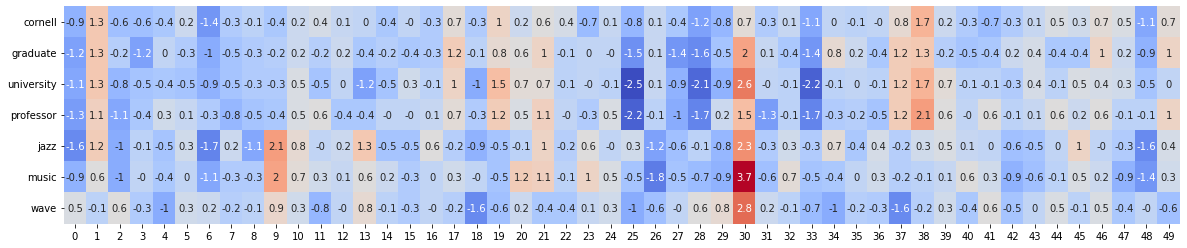

In [10]:
plt.rcParams['figure.figsize'] = [20, 4]   # plot wider figures
ax = sns.heatmap(df.loc[LsQueryWords].round(1), annot=True, cmap='coolwarm', cbar=False);
tmp = ax.set_title('');

<span style="color:black"> With this color-coded matrix, you can now identify columns (i.e., vector dimensions) that embed "education-ness" and "music-ness." For example, columns 33, 37, and 38 appear to distinguish education-related words from music-related terms. You will not know what these columns represent exactly, but you can use this information to help cluster terms together.

## Using Dot Product to Understand Semantic Similarity

<span style="color:black">A technique for comparing semantic similarity between two vectors is by calculating their dot product (i.e., sum product). A high number implies greater semantic similarity between two words. 
    
<span style="color:black">Note that this is not alphabetic similarity (at least not directly) but semantic similarity, where the meanings of words are captured by values in dimensions (or some fuzzy categories), in which these words have a meaning. So, a vector for "cornell" should be similar to words relating to education, to Cornell family, to East Coast, to technology, and many other topics that we associate Cornell with. That's because in training these models, the word "Cornell" appeared in these contexts in training corpora (Wikipedia and Gigaword) so the model learned these associations.

In [11]:
df.loc['cornell',:] @ df.loc['graduate',:]

20.122221

<span style="color:black">It can be hard to tell whether the dot product is high or low because the value is relative rather than standardized. You need to compare multiple dot products to gauge what qualifies as high and low in the context of the model and your question.

In [12]:
df.loc['cornell',:] @ df.loc['university',:]
df.loc['cornell',:] @ df.loc['fish',:]

23.354948

2.2978904

<span style="color:black"> The dot product between (vectors of) '*cornell*' and '*fish*' is notably closer to zero than between (vectors of) '*cornell*' and '*university*', demonstrating that there is a strong (linear) relationship between (vectors of) '*cornell*' and '*university*'.

<span style="color:black"> A cosine similarity is a more interpretable metric. It is a standardized measure in $[-1,1]$, where $-1=$ highest dissimilarity and $+1=$ highest similarity. It allows you to judge the semantic relation of each pair of word vectors independently without relative comparisons. In cosine similarity, you standardize the length of each vector to be of one unit before applying a dot product. Vector-length standardization does not change their orientation. Essentially, you are computing the cosine of the angle between two vectors, $x$ and $y$, ignoring their lengths.

$$\text{CosSim}(x,y):=\frac{x'y}{||x||\cdot||y||}=\frac{x'y}{\sqrt{x'x\cdot y'y}}$$

<span style="color:black">The function `CosSim` computes cosine similarity of two vectors (of the same dimension or size, of course).

In [13]:
CosSim = lambda x,y: x @ y / (x @ x)**0.5 / (y @ y)**0.5
Word_CosSim = lambda w1,w2: print( f"CosSim('{w1}', '{w2}') = {CosSim(wv[w1], wv[w2]):.3f}" )

Word_CosSim('cornell', 'university')
Word_CosSim('cornell', 'fish')

CosSim('cornell', 'university') = 0.784
CosSim('cornell', 'fish') = 0.090


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

In this exercise, you will investigate the distributions of parameters in the `wv` object.

As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

## Task 1


Compute the mean, standard deviation, min, median, and max for all $400K\times50$ values in `wv`. 

1. What is the center of the distribution of these parameters? 
1. Do the basic stats suggest symmetry or skew of the distribution? 

Note: These questions help you understand the distribution of word vectors, so that if you observe a notably different distribution after training your own word vectors, you can detect, investigate, and fix the problem. Note that while each corpus will likely result in different coefficients of word vectors, the distribution should mainly remain similar to the current distribution.

<b>Hint:</b> You can retrieve all values from a DataFrame as a NumPy array using <code>values</code> attribute. Then use <code>ravel()</code> to flatten this 2D array into a 1D array. Then you can use NumPy's statistical methods <code>mean(), min(), std(), min(), median(), max()</code> to compute basic stats.


In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
npPar = df.values.ravel()   # weights
npPar.mean(), npPar.std(), npPar.min(), np.median(npPar), npPar.max()
    </pre>The distribution appears to be symmetric and centered at about zero. Note that the mean is approximately equal to the median (in units of standard deviation), indicating that the skew is insignificant. The left and right tails of the histogram are also of approximate length (about 5.35).
    </details> 
</font>
<hr>

## Task 2

Plot a histogram (with 100 bins) for all $400K\times50$ parameters.

1. What is the center of the distribution of these parameters? 
1. Does the distribution appear symmetric or skewed? 

<b>Hint:</b> If you retrieve a flattened list of all <code>wv</code> parameters as above, then you can wrap the array as a dataframe again and call <code>hist()</code> method with appropriate parameters. See documentation of this method.


In [ ]:
# check solution here

<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
pd.DataFrame(npPar).hist(bins=100, alpha=0.5, density=True);
    </pre>The center of the histogram appears around value 0, where there is the top of the bell curve. This implies that largest counts of observations are in the interval around 0 value. The distribution appears symmetric. That is, if we (mentally) flip the horizontal axis, the new histogram will approximately overlay the current histogram. 
    </details> 
</font>
<hr>

## Task 3

Plot a histogram for columns with index 37 parameters that appear to be related to education. Use the same range (i.e., min and max values) as those observed in the histogram in the Task 2.

1. What is the center of the distribution of these parameters? 
1. Does the distribution appear symmetric or skewed? 
1. How is it different from the distribution of all parameters above? I.e., any observable shift, scale, skew?

<b>Hint:</b> Use the <code>iloc</code> attribute of a DataFrame to reference columns and rows by their index. See documentation. Once you retrieve a column, it's a Pandas Series object but still has a <code>hist()</code> method.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
df.iloc[:,37].hist(bins=100, alpha=0.5, density=True, range=[npPar.min(), npPar.max()]);
    </pre>As before, the center (mean and median) of this histogram appears to be around the value 0. The histogram appears to be symmetric (with the similar tapering of the tails to the left and to the right of the zero value). The current histogram appears a bit narrower and a bit taller (at zero) than the previous, indicating that more Word2Vec coefficient values are concentrated around the zero values. The extreme low and high coefficient values are still in the similar range of about -4 to 4.
    </details> 
</font>
<hr>

## Task 4

Think of 10 lowercase words that you strongly relate to education and save them as a list of strings, `LsEduSeed`. Use these seed words to find a larger number of related words. If the words are not in `wv`'s vocabulary, replace them with different words. Now, retrieve all words from `wv`'s vocabulary that contain any of the seed words you ideated. Save the resulting words to `LsEdu` as a list of strings. 

For example, if you had a word `'university'` as a seed, then `LsEdu` will contain `'university'`, `'pre-university'`, `'interuniversity'`, `'non-university'`, `'university-level'` ...

<b>Hint:</b> You might need a double loop where one is going over the seed words and the other pulls all words from vocabulary, which contain the current seed word. Pick words that have a narrow education-focused meaning. For example "class" has many non-education meanings. You can Google for more ideas.


In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
LsEduSeed = ['university','professor','cornell','graduate','student','school','study','homework','research','academia']
[w for w in LsEduSeed if w not in wv.key_to_index] # print words, which are not in wv's vocabulary
def WordsInVocab(LsQuery):
    LL = [[w for w in wv.key_to_index if q in w] for q in LsQuery]
    return [l for L in LL for l in L]
LsEdu = WordsInVocab(LsEduSeed)
print(f'found {len(LsEdu)} words')
print(LsEdu[:10])
    </pre>
    </details> 
</font>
<hr>

## Task 5

Retrieve all word vectors for words in `LsEdu` and save them as a DataFrame `dfEdu` with the corresponding words as indices.

<b>Hint:</b> Try a list comprehension to retrieve word vectors. Then wrap the results into a DataFrame object.


In [ ]:
# check solution here

<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
Solution 1:
dfEdu = pd.DataFrame([GetWV(w) for w in LsEdu], index=LsEdu)
dfEdu

Solution 2:
dfEdu = pd.DataFrame(wv[LsEdu], index=LsEdu)
dfEdu
    </pre>
    </details> 
</font>
<hr>

## Task 6

Create a list of words strongly relating to music and save to `LsMusSeed` (as you did above with education). Then retrieve all words from `wv`'s vocabulary, if they contain the music seed words. Finally, retrieve their word vectors and package them all into a DataFrame `dfMus` as you did above. 

<b>Hint:</b> This is similar to the code above.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
LsMusSeed = ['music', 'jazz', 'violin', 'sound', 'wave', 'guitar', 'flute', 'speaker', 'drum', 'microphone']
[w for w in LsMusSeed if w not in wv.key_to_index] # print words, which are not in wv's vocabulary
LsMus = WordsInVocab(LsMusSeed)
dfMus = pd.DataFrame([GetWV(w) for w in LsMus], index=LsMus)
    </pre>
    </details> 
</font>
<hr>

## Task 7

Plot a blue histogram for the parameters in column 33 for `dfEdu` and then overlay a green histogram for the parameters in the same column for `dfMus`. Use 30 bins and alpha transparency of 0.3.

1. Are these histograms similar in location and shape?

<b>Hint:</b> Once you retrieve a Pandas Series containing a column, use its <code>hist()</code> method as before. See documentation for the method's parameters.


In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
dfEdu.iloc[:,33].hist(bins=30, alpha=0.3, color='blue', density=True);
dfMus.iloc[:,33].hist(bins=30, alpha=0.3, color='green', density=True);
    </pre>The blue histogram appears to be centered about -0.25, while the green histogram is centered at a value closer to zero. The histograms appear symmetric. Overall this implies that the selected "music" coefficients are slightly more positive on average than the "education" coefficients are. Understanding the distributions of the coefficients can help reveal problems with training Word2Vec vectors. Thus, if you train new Word2Vec vectors and observe distributions that are unusually thin (too many concentrated values) or value concentrations too far from zero, or strongly skewed distributions, or drastically different range (say, much larger than the current [-2,-2]), then the training may not have been done correctly. Perhaps more training iterations or a larger training sample needs to be sought.
    </details> 
</font>
<hr>